In [20]:
import numpy as np
import pandas as pd
import os  
import sys

import os.path
from pprint import pprint
import time
from io import BytesIO

from random import random
import uuid


from azure.cognitiveservices.vision.contentmoderator import ContentModeratorClient
from azure.cognitiveservices.vision.contentmoderator.models._models_py3 import Screen
import azure.cognitiveservices.vision.contentmoderator.models
from msrest.authentication import CognitiveServicesCredentials
import time


CONTENTMODERATOR_ENDPOINT = os.environ.get("CONTENT_MODERATOR_ENDPOINT")
subscription_key = os.environ.get("CONTENT_MODERATOR_SUBSCRIPTION_KEY")



PATH = 'data/HateSpeechDataset/'
TRAIN = 'sampled_train/'
TEST = 'sampled_test/'
ALL ='all_files/'


keys = pd.read_csv(PATH + 'annotations_metadata.csv')
keys.head()

all_list = []
for filename in os.listdir(PATH + ALL):
    with open(PATH + ALL + filename) as inp:
        data = list(inp)
        no_ext = filename.rsplit( ".", 1 )[ 0 ] 
        all_list.append([no_ext, data[0]]) 

train_list = []
for filename in os.listdir(PATH + TRAIN):
    with open(PATH + TRAIN + filename) as inp:
        data = list(inp)
        no_ext = filename.rsplit( ".", 1 )[ 0 ] 
        train_list.append([no_ext, data[0]])
        
test_list = []
for filename in os.listdir(PATH + TEST):
    with open(PATH + TEST + filename) as inp:
        no_ext = filename.rsplit( ".", 1 )[ 0 ] 
        data = list(inp)
        test_list.append([no_ext, data[0]])

train = pd.DataFrame(train_list, columns = ['id','examples'])
test = pd.DataFrame(test_list, columns = ['id','examples'])
all_files = pd.DataFrame(all_list, columns = ['id','examples'])

In [3]:
#now, all should have the correct id values to join 
train.shape, test.shape, all_files.shape

((1914, 2), (478, 2), (10944, 2))

In [4]:
train = pd.merge(train, keys, how='left', left_on='id', right_on='file_id')
train.drop(columns=['file_id'])
test = pd.merge(test, keys, how='left', left_on='id', right_on='file_id')
test.drop(columns=['file_id'])
all_files = pd.merge(all_files, keys, how='left', left_on='id', right_on='file_id')
all_files.drop(columns=['file_id']) 

,id,examples,user_id,subforum_id,num_contexts,label
0,13458115_2,It 's like that at most public boards .,572266,1347,0,noHate
1,13367480_1,I wonder if one of the victims opened the door...,572710,1345,0,noHate
2,30422449_1,Some people believe the Jack O ' Lantern also ...,576917,1348,0,noHate
3,14651837_4,Ready .... GO !!!,572043,1371,0,noHate
4,30527903_3,Thanks !,573458,1359,0,noHate
...,...,...,...,...,...,...
10939,13472256_1,"Also, it 's so sad to see so much pre made cra...",575539,1346,0,noHate
10940,14417873_2,CF,573658,1375,0,noHate
10941,30597853_3,Sorry that you were unaware .,577560,1354,0,noHate
10942,30626265_1,My grandmother Has Red Hair .,587276,1348,0,noHate


In [5]:
#make the client
client = ContentModeratorClient(
    endpoint=CONTENTMODERATOR_ENDPOINT,
    credentials=CognitiveServicesCredentials(subscription_key)
)

In [6]:
mods = []
counter = 0
lost_f = []
ids = []

counter_done = 0 
for filename in os.listdir(PATH + ALL):
    counter_done += 1
    with open(PATH + ALL + filename) as inp: 
        try:
            screen = client.text_moderation.screen_text(
                    text_content_type="text/plain",
                    text_content=inp,
                    language="eng",
                    autocorrect=True,
                    pii=True,
                    classify=True
            )
            mods.append(screen.as_dict())
            ids.append(filename) 
        except:
            lost_f.append(filename)
            print('lost file', filename)
            counter += 1
    if counter_done > 3000:
        print("DONE!!!!")
        break
    
print("lost this many:", counter)   
assert len(mods) == len(ids)

lost file 13591250_2.txt
lost file 14027771_2.txt
lost file 13493681_1.txt
lost file 14434772_4.txt
lost file 13868014_1.txt
lost file 13601312_1.txt
lost file 13591250_3.txt
lost file 13497385_1.txt
lost file 13566980_2.txt
lost file 13458373_2.txt
lost file 13868014_2.txt
lost file 13591250_4.txt
lost file 13587851_1.txt
lost file 13443527_2.txt
lost file 13588794_3.txt
lost file 14065492_1.txt
lost file 30791003_4.txt
lost file 13621261_2.txt
lost file 31712702_1.txt
lost file 30734623_1.txt
lost file 13591250_5.txt
lost file 13591250_7.txt
lost file 30657972_5.txt
lost file 14067641_2.txt
lost file 14434772_1.txt
lost file 30420836_2.txt
lost file 13505642_1.txt
lost file 13621261_1.txt
lost file 30601733_1.txt
lost file 14050476_1.txt
lost file 31721425_1.txt
lost file 13852100_1.txt
DONE!!!!
lost this many: 32


In [8]:
for file in lost_f:
    with open(PATH + ALL + file) as inp:
        print(list(inp), '\n')

['Sørensen , 19 år , er født 8. april 1982 i Kolding .'] 

['André Rieu - The Beautiful Blue Danube - YouTube'] 

['Ivan Ivanovich Shishkin , January 25 , 1832 March 20 , 1898 ( Иван Иванович Шишкин ) Felling of Forest , 1867 Landscape with a Lake At the Seashore , 1890 ( sketch ) Birch Grove , 1896 View at a Neighborhood of Petersburg , 1856 Swiss Landscape , 1866 Forest on the Eve of Thunderstorm , 1872 Oak Forest in a Grey day , 1873 ( sketch ) Swamp .'] 

['Daniel Wretström march And their website : http://www.salemfonden.info/ ( currently seems to be down but usually works just fine )'] 

['Latha math dhuibh agus dè tha dol agad fhèin , a Phàdruig/Hello Pat , how are you ?'] 

["I'm back and I hope that Teárlach is too or at least that JJT brave enugh to tell me who did it ."] 

['Har taget en HH-eksamen på handelsskolen i Nyborg .'] 

['Edin D eko Bosnian soccer player Zvjezdan Misimović Mismovic and D eko Bosnian President Zeljko Komsic and Angela Lejla Damardzic Bosnian Special

In [16]:
#parse out the classifications score! 
mods_df = pd.DataFrame(mods)
cats = mods_df['classification'].apply(pd.Series)
cats['category1'] = cats['category1'].apply(lambda x: x.get('score'))
cats['category2'] = cats['category2'].apply(lambda x: x.get('score'))
cats['category3'] = cats['category3'].apply(lambda x: x.get('score'))


dict_names = {'category1': 'sexually_explicit_adult', 
              'category2':'sexually_suggestive_mature', 
              'category3':'offensive'
             }
cats = cats.rename(columns=dict_names)
ids = pd.DataFrame(ids)
ids = ids[0].apply(lambda x: x.rsplit( ".", 1 )[ 0 ])
cats = pd.concat([cats, ids], axis=1)
cats.rename(columns={0:'ids'}, inplace=True)

all_class = pd.merge(cats, all_files, how='left', left_on='ids', right_on='id')
all_class.drop(columns=['id', 'file_id'], inplace=True)
all_class = all_class.set_index('ids')
all_class.head()


,sexually_explicit_adult,sexually_suggestive_mature,offensive,review_recommended,examples,user_id,subforum_id,num_contexts,label
ids,,,,,,,,,
13458115_2,0.015370,0.134904,0.118710,False,It 's like that at most public boards .,572266,1347,0,noHate
13367480_1,0.037245,0.109521,0.155028,False,I wonder if one of the victims opened the door...,572710,1345,0,noHate
30422449_1,0.000104,0.169795,0.201602,False,Some people believe the Jack O ' Lantern also ...,576917,1348,0,noHate
14651837_4,0.024580,0.229663,0.068351,False,Ready .... GO !!!,572043,1371,0,noHate
30527903_3,0.009377,0.229663,0.069737,False,Thanks !,573458,1359,0,noHate


In [30]:
#false positive
false_pos = all_class[(all_class['review_recommended'] == True) & (all_class['label'] == 'noHate')]
false_pos.head(20)

# false_neg = all_class[(all_class['review_recommended'] == False) & (all_class['label'] == 'hate')] 
# false_neg.head(20) 

# true_pos = all_class[(all_class['review_recommended'] == True) & (all_class['label'] == 'hate')]
# true_pos.head(20)

# true_neg = all_class[(all_class['review_recommended'] == False) & (all_class['label'] == 'noHate')]
# true_neg.head(40)



,sexually_explicit_adult,sexually_suggestive_mature,offensive,review_recommended,examples,user_id,subforum_id,num_contexts,label
ids,,,,,,,,,
13617074_1,3.384125e-02,0.096128,0.988000,True,"Why, are you afraid that your son might come and find you drunk in a bar 20 years later and try to kill you or something ...",572043,1393,0,noHate
13449582_3,1.101689e-01,0.206300,0.988000,True,Just the yo crap .,572427,1347,0,noHate
14296672_3,6.664865e-01,0.212040,0.079302,True,Please message me .,575071,1380,0,noHate
30623737_5,4.593397e-08,0.822081,0.988000,True,"Here 's some good anime : `` Cowboy Bebop '' ( real title is `` Heaven 's Gate '' ) [ generally ok for kids ] `` Akira '' [ a little disturbing for youngsters ] `` Princess Mononoke '' [ kid ok ] `` Spirited Away '' [ kid ok ] `` Robotech '' [ kid ok ] `` Golgo 13 '' [ violent ] `` Ninja Scrolls '' [ violent , sexual situations ] `` Vampire Hunter D '' [ violent ] `` Animatrix '' [ violent - mature kids only ] Check out `` adult swim '' on Comedy Central late at night .",579195,1362,0,noHate
14270522_1,2.189376e-03,0.048873,0.988000,True,I heard the feds got him because he ate a chocolate bar and they charged him with racist eating. lol Now im sure he is ok atleast I hope so I look forward to his reading his wisdom as often as he posts it .,573684,1380,0,noHate
14669948_3,1.815221e-02,0.229663,0.501522,True,#WethePeople #RealAmericans,614438,1371,1,noHate
30390371_1,7.387078e-03,0.232052,0.988000,True,"In the old days private security and armed whites would take care of this , but maybe the negros are fighting smarter by taking on soft-targets ?",572482,1396,0,noHate
13473247_4,5.177660e-01,0.288671,0.641480,True,I have seen young white girl 's and boy 's acting like blacks with their baggy pant 's and their hip hop .,583605,1346,0,noHate
30431013_2,4.817475e-02,0.274022,0.988000,True,Alot of blue missing but it always goes bang and fits in my pants pocket better than my Taurus tip up .,577207,1359,3,noHate


In [11]:
all_class.to_csv(r'micro1_first_3000.csv')

In [12]:
#play around with the dataset
sexual = all_class[all_class['sexually_explicit_adult'] > .5]
suggestive = all_class[all_class['sexually_suggestive_mature'] > .5]
offensive = all_class[all_class['offensive'] > .5]

hate = all_class[(all_class['offensive'] > .4) & (all_class['label'] == 'hate')]


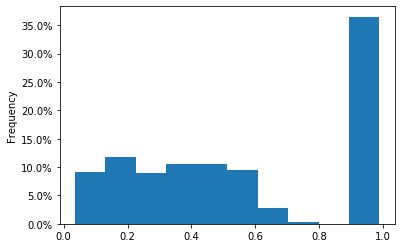

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

hate_true = hate = all_class[all_class['label'] == 'hate']
hate_true.head()

hate_true['offensive'].plot(kind='hist', weights=np.ones(len(hate)) / len(hate))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()
